In [61]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data")
RESULTS = Path("../results/q1")
RESULTS.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({"figure.figsize": (8,5), "font.size": 12})

# Table 1
df = pd.DataFrame({
    "x": np.array([0,1,2,3,4,5,6,7,8,9], dtype=float),
    "y": np.array([20.26,5.61,3.14,-30.00,-40.00,-8.13,
                   -11.73,-16.08,-19.95,-24.03], dtype=float)
})
df

,x,y
0,0.0,20.26
1,1.0,5.61
2,2.0,3.14
3,3.0,-30.00
4,4.0,-40.00
5,5.0,-8.13
6,6.0,-11.73
7,7.0,-16.08
8,8.0,-19.95
9,9.0,-24.03


In [62]:
# Fit y = a x + b by least squares
X = np.c_[df["x"].to_numpy(), np.ones(len(df))]
theta, *_ = np.linalg.lstsq(X, df["y"].to_numpy(), rcond=None)
a_hat, b_hat = theta
print(f"OLS model: y ≈ {a_hat:.4f} x + {b_hat:.4f}")

OLS model: y ≈ -3.5573 x + 3.9167


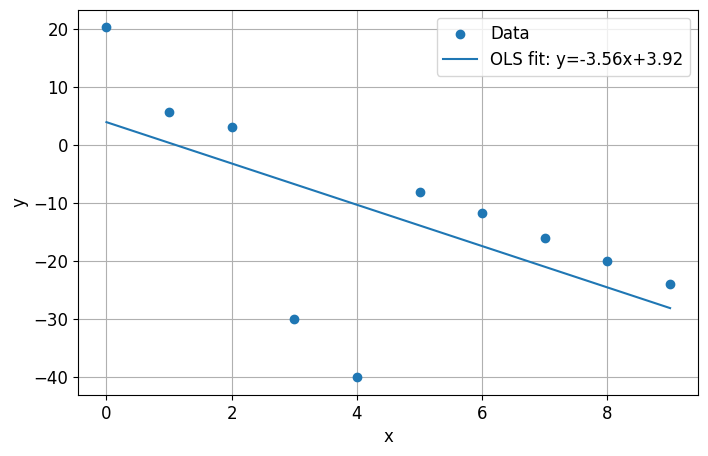

In [63]:
# Plot scatter + fitted line
x_plot = np.linspace(df["x"].min(), df["x"].max(), 200)
y_plot = a_hat * x_plot + b_hat

plt.scatter(df["x"], df["y"], label="Data", zorder=3)
plt.plot(x_plot, y_plot, label=f"OLS fit: y={a_hat:.2f}x+{b_hat:.2f}")
# plt.title("Scatter plot with OLS linear regression line")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.savefig(RESULTS/"dataset_vs_lstsq_model.png", dpi=150)
plt.show()

In [64]:
def robust_loss(y_true, y_pred, beta):
    e2 = (y_true - y_pred)**2
    return np.mean(e2 / (e2 + beta**2))

# "Model x": (slope, intercept)
models = {"Model 1": (-4.0, 12.0), "Model 2 (learned)": (-3.55, 3.91)}

betas = [1.0, 1e-6, 1e3]
rows = []

for name, (a, b) in models.items():
    y_hat = a * df["x"].to_numpy() + b
    for beta in betas:
        L = robust_loss(df["y"].to_numpy(), y_hat, beta)
        rows.append({"Model": name, "beta": beta, "L(theta,beta)": round(L, 4)})

robust_df = pd.DataFrame(rows)
robust_df

,Model,beta,"L(theta,beta)"
0,Model 1,1.000000,0.4354
1,Model 1,0.000001,1.0000
2,Model 1,1000.000000,0.0002
3,Model 2 (learned),1.000000,0.9728
4,Model 2 (learned),0.000001,1.0000
5,Model 2 (learned),1000.000000,0.0002


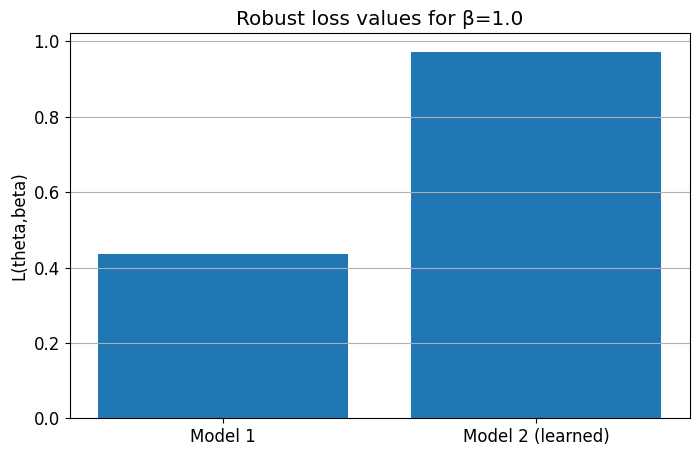

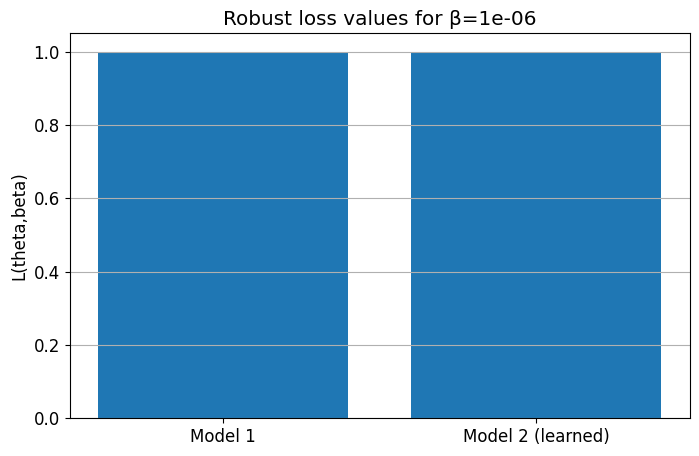

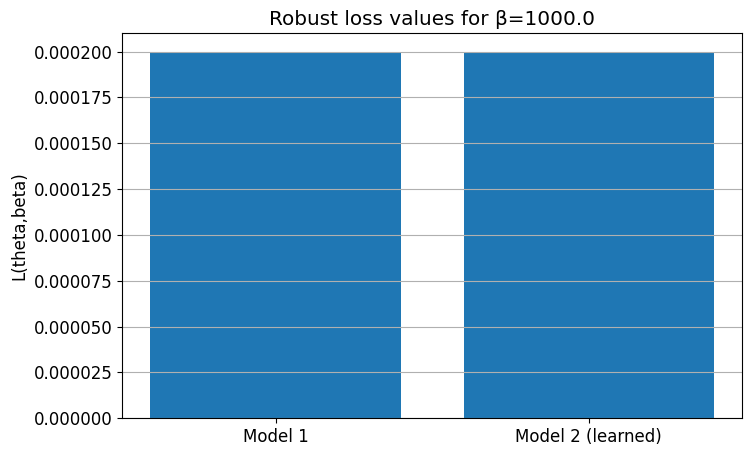

In [65]:
for beta in betas:
    subset = robust_df[robust_df["beta"] == beta]
    plt.bar(subset["Model"], subset["L(theta,beta)"])
    plt.title(f"Robust loss values for β={beta}")
    plt.ylabel("L(theta,beta)")
    plt.grid(True, axis="y")
    plt.savefig(RESULTS/f"robust_loss_beta={beta}.png", dpi=150)
    plt.show()

In [66]:
x_val = df["x"].to_numpy()
y_val = df["y"].to_numpy()

# After fitting OLS
yhat_val = a_hat * df["x"].to_numpy() + b_hat
r = df["y"].to_numpy() - yhat_val

# r = residuals from an initial OLS fit (shape: [N])
med = np.median(r)
sigma_hat = 1.4826 * np.median(np.abs(r - med))  # robust scale (MAD)

# Try a small grid around sigma_hat
beta_grid = [0.5*sigma_hat, 1.0*sigma_hat, 1.5*sigma_hat, 2.0*sigma_hat, 3.0*sigma_hat]


def robust_loss_vec(y, yhat, beta):
    e2 = (y - yhat)**2
    return np.mean(e2 / (e2 + beta**2))


# pick the β with the lowest validation loss (or training loss if no split)
best_beta = min(beta_grid, key=lambda b: robust_loss_vec(y_val, yhat_val, b))

print(f"Best beta: {best_beta}")

Best beta: 3.715934727272737


In [67]:
def huber_loss(y_true, y_pred, delta=1.0):
    residual = y_true - y_pred
    abs_res = np.abs(residual)
    quadratic = 0.5 * (residual**2)
    linear = delta * (abs_res - 0.5 * delta)
    return np.mean(np.where(abs_res <= delta, quadratic, linear))

In [68]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
beta_grid = [0.5*sigma_hat, 1.0*sigma_hat,
             1.5*sigma_hat, 2.0*sigma_hat, 3.0*sigma_hat]


def pick_beta_kfold(X, y, beta_grid):
    scores = {b: [] for b in beta_grid}
    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # fit OLS on this fold's TRAIN
        X_tr_design = np.c_[X_tr[:, 0], np.ones(len(X_tr))]
        a_b, *_ = np.linalg.lstsq(X_tr_design, y_tr, rcond=None)
        a_f, b_f = a_b

        # predict on VALIDATION and accumulate robust loss for each β
        yhat_va = a_f * X_va[:, 0] + b_f
        for b in beta_grid:
            scores[b].append(robust_loss_vec(y_va, yhat_va, b))

    # average across folds and pick best β
    mean_scores = {b: np.mean(v) for b, v in scores.items()}
    return min(mean_scores, key=mean_scores.get), mean_scores


best_beta_cv, mean_scores = pick_beta_kfold(X, y, beta_grid)
print("K-fold β scores:", mean_scores)
print("Chosen β (K-fold):", best_beta_cv)

ModuleNotFoundError: No module named 'sklearn'